Conectado a la base de datos.
Datos cargados exitosamente.

Tipos de datos de las columnas:
movie_id                  int64
titulo                   object
release_date             object
duracion                  int64
vote_average             object
vote_count                int64
revenue                 float64
budget                  float64
adult                      bool
belong_to_collection     object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
spoken_languages         object
status                   object
tagline                  object
genero                   object
dtype: object
Primeras 10 filas del DataFrame:     movie_id                                             titulo release_date  \
0   1265354  Irlande du Nord, la frontière de tous les dangers   2024-03-26   
1   1265354  Irlande du Nord, la frontière de tous les dangers

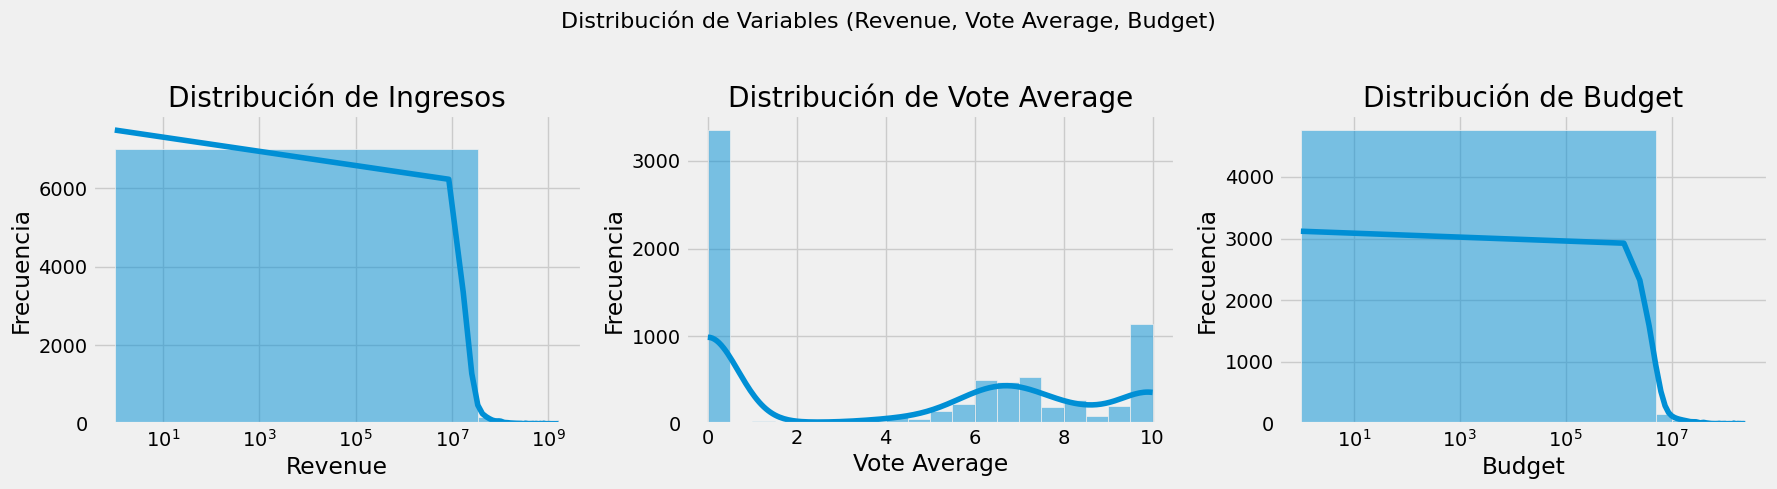

Umbral de True Revenue (mediana de valores > 9999): 1087016.0
Umbral de Calificación Promedio: 6.5
Umbral de Conteo de Votos: 1.0
Umbral de Popularidad: 0.06

Distribución de la variable 'exito':
exito
0    6578
1     814
Name: count, dtype: int64

--- Visualización de Nuevas Características Clave y su Relación con el Éxito ---


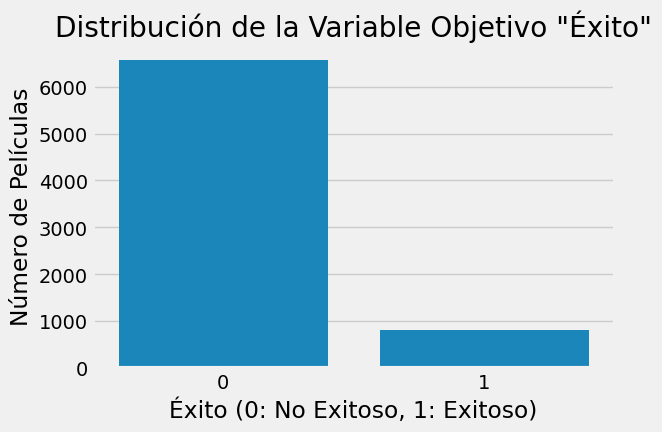

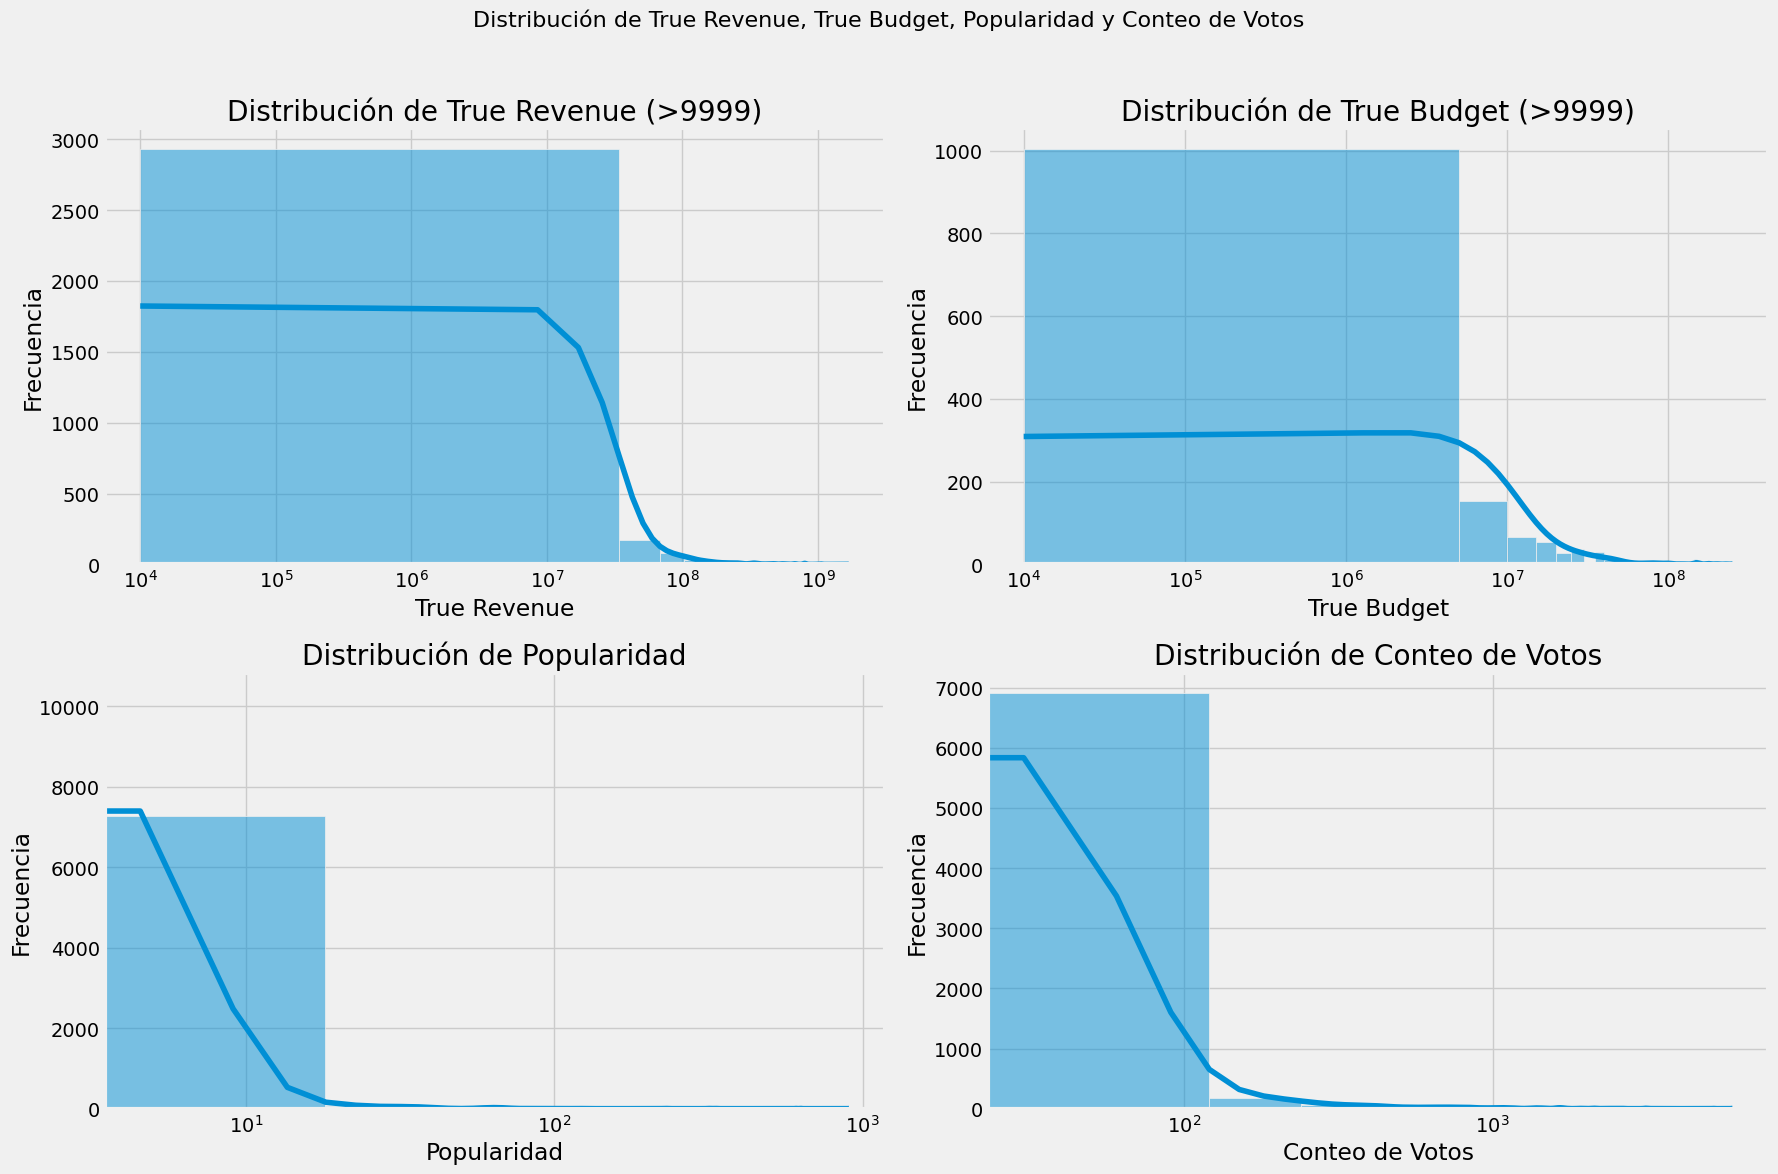

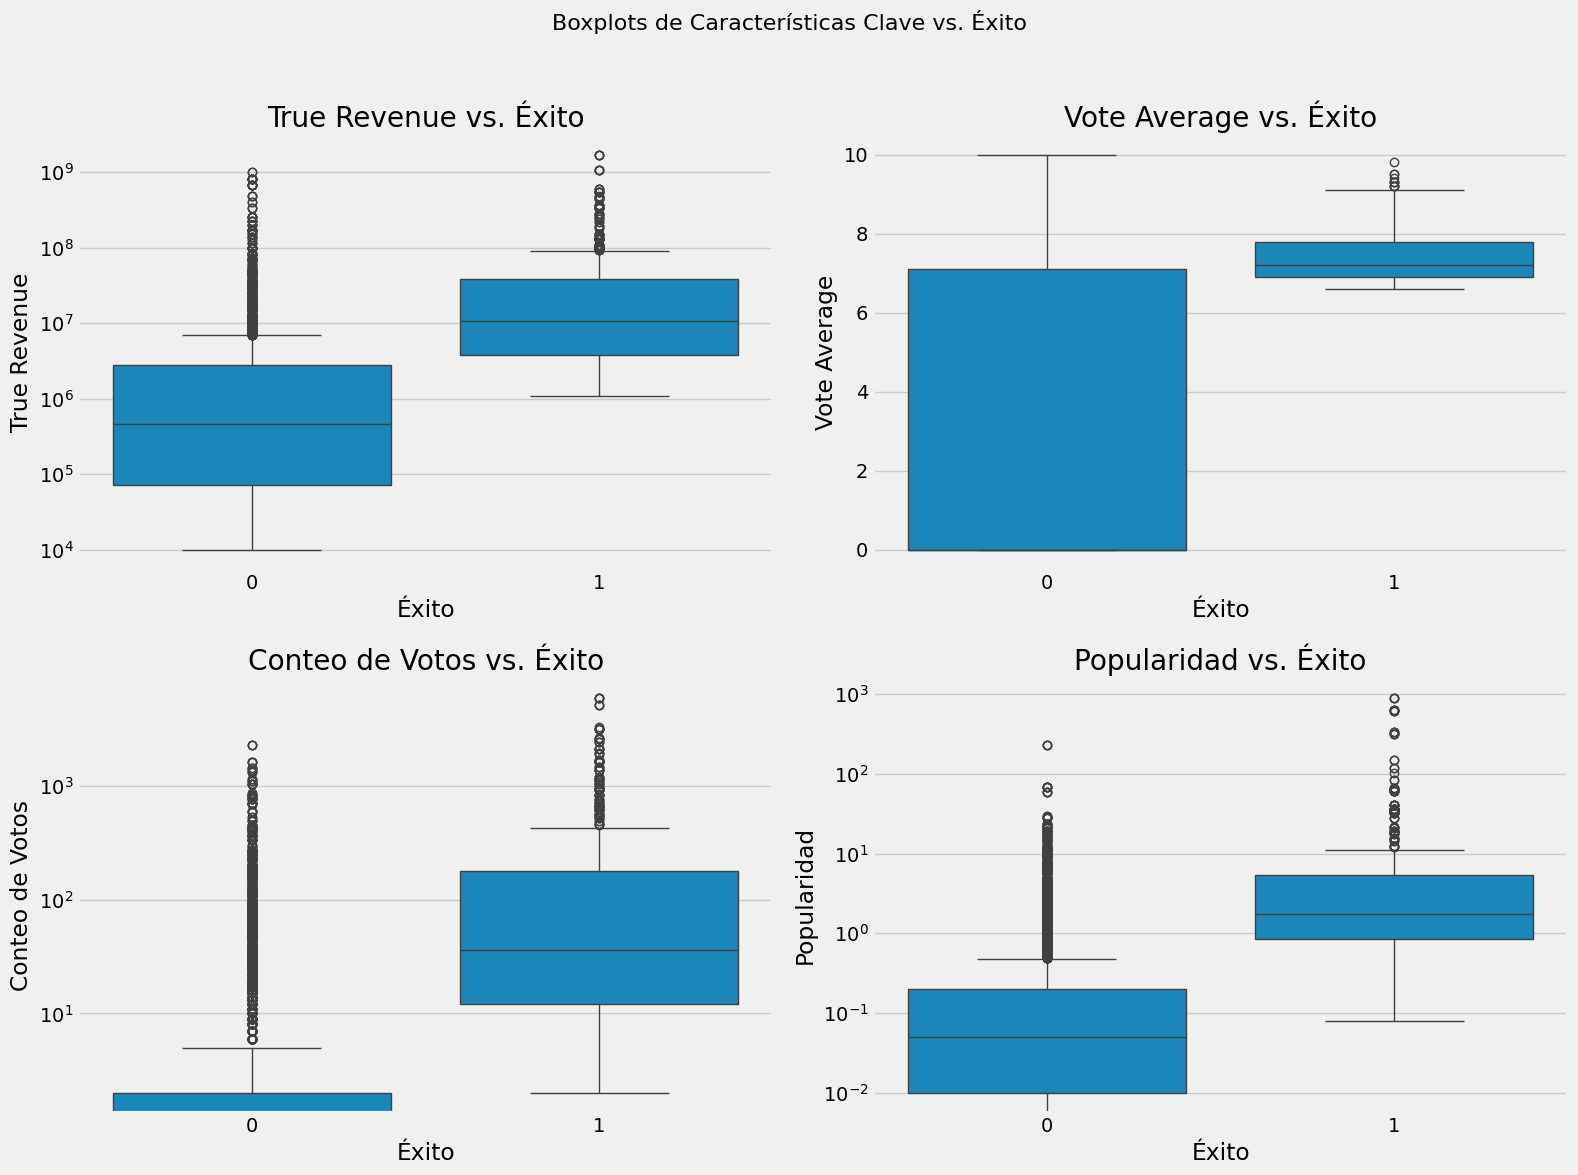


--- Proporción de Éxito por Categoría ---


C:\Users\plg_1\AppData\Local\Temp\ipykernel_25684\2672555902.py:324: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y='exito', data=df_cleaned, ci=None)
C:\Users\plg_1\AppData\Local\Temp\ipykernel_25684\2672555902.py:321: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y='exito', data=df_cleaned, ci=None, order=order)
C:\Users\plg_1\AppData\Local\Temp\ipykernel_25684\2672555902.py:324: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y='exito', data=df_cleaned, ci=None)
C:\Users\plg_1\AppData\Local\Temp\ipykernel_25684\2672555902.py:324: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y='exito', data=df_cleaned, ci=None)
C:\Users\plg_1\AppData\Local\Temp\ipykernel_25684\2672555902.py:324: FutureWarning: 

The `ci` parameter is

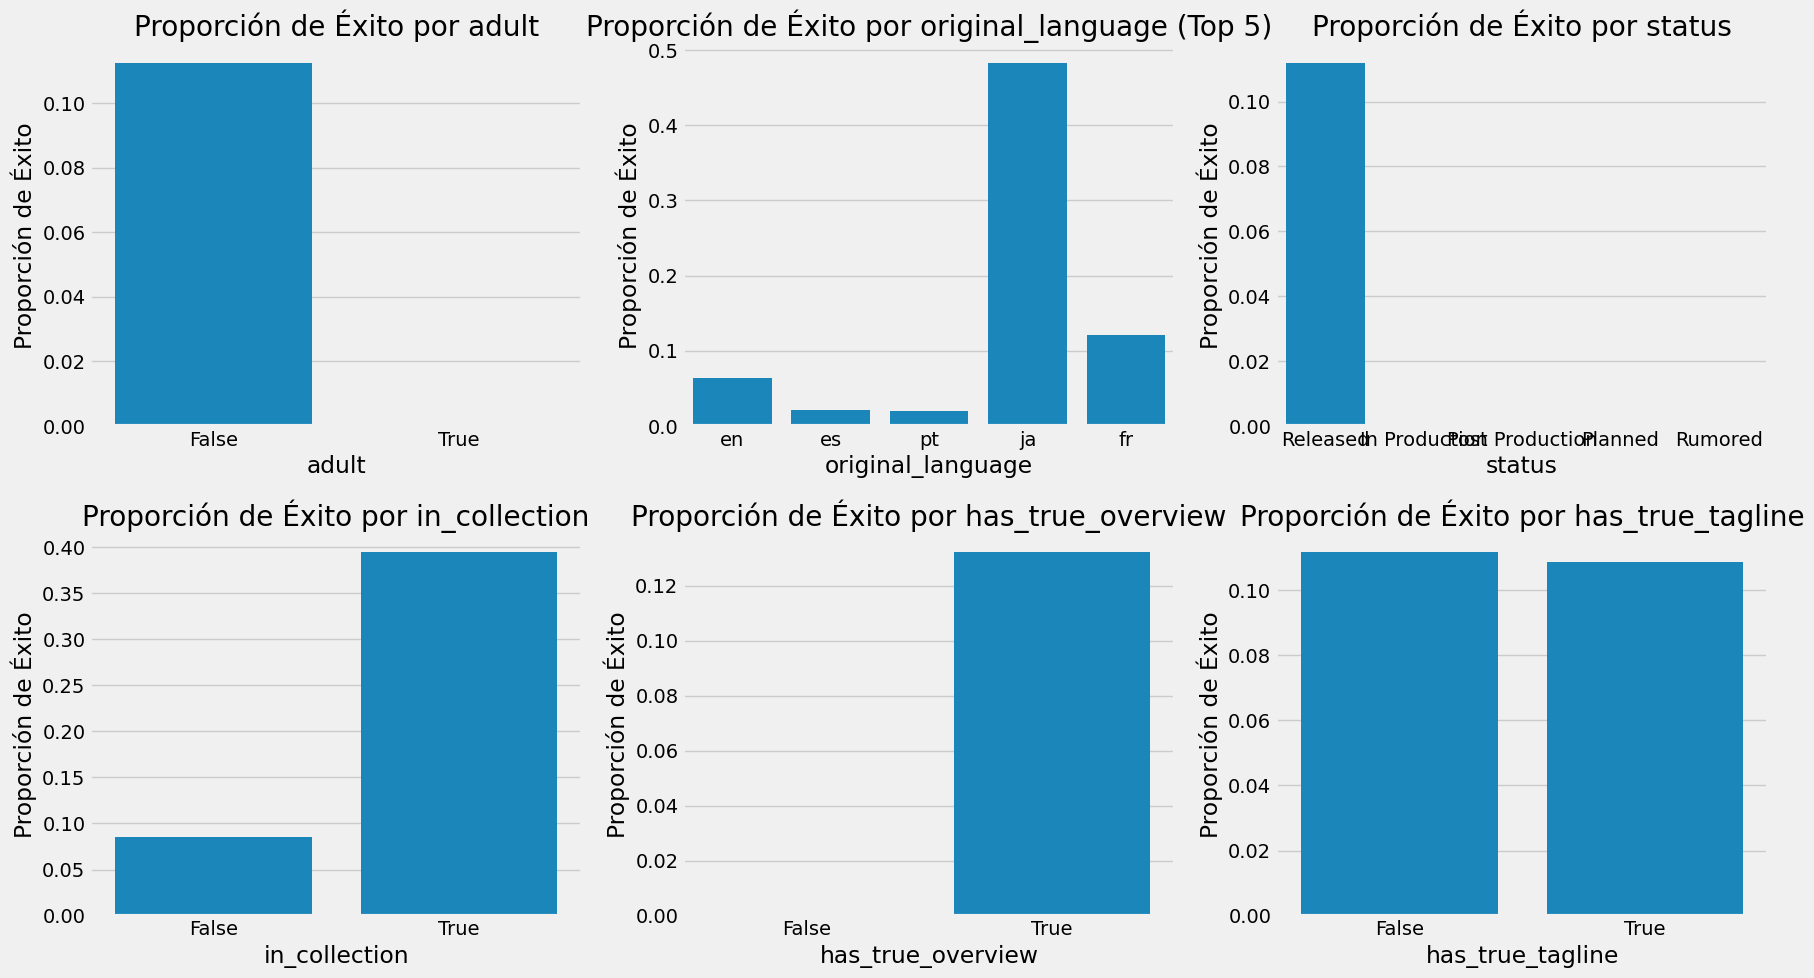


--- Preparando los datos para el modelo ---


C:\Users\plg_1\AppData\Local\Temp\ipykernel_25684\2672555902.py:344: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pre_model[col].fillna(df_pre_model[col].mean(), inplace=True)
C:\Users\plg_1\AppData\Local\Temp\ipykernel_25684\2672555902.py:397: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

Forma de las variables predictoras (X): (3650, 143)
Forma de la variable objetivo (y): (3650,)
Tamaño del conjunto de entrenamiento: 2920 muestras
Tamaño del conjunto de prueba: 730 muestras

--- Entrenamiento del Modelo de Clasificación ---
Modelo entrenado con éxito.

--- Evaluación del Modelo ---
Precisión del modelo: 0.93

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       665
           1       0.73      0.37      0.49        65

    accuracy                           0.93       730
   macro avg       0.83      0.68      0.73       730
weighted avg       0.92      0.93      0.92       730


Matriz de Confusión:
[[656   9]
 [ 41  24]]


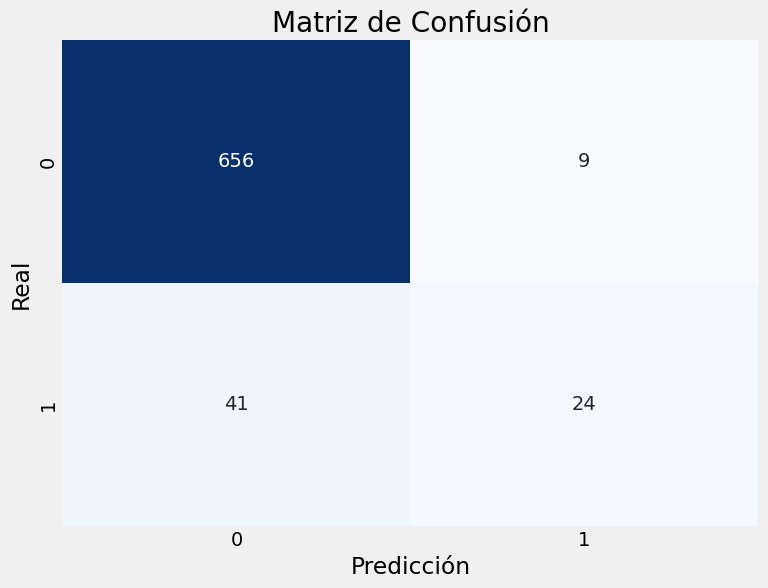

Modelo guardado como 'model.pkl'.

--- Proceso completado ---


In [3]:
import pandas as pd
import numpy as np
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re 
import boto3, json, os, pickle
from dotenv import load_dotenv

# Conexión BD

load_dotenv()  
secret_name = os.getenv("DB_KEY")
region      = os.getenv("REGION")


client   = boto3.client("secretsmanager", region_name=region)
response = client.get_secret_value(SecretId=secret_name)
creds    = json.loads(response["SecretString"])


db_config = {
    "host":     creds["host"],
    "dbname":   creds["dbname"],
    "user":     creds["username"], 
    "password": creds["password"],
    "port":     creds.get("port", 5432)
}


conn = None
cursor = None
df = None

try:
        
    conn = psycopg2.connect(**db_config)
    print("Conectado a la base de datos.")

    # Crear un objeto cursor
    cursor = conn.cursor()

    # Consulta SQL para cargar las tablas necesarias, incluyendo las nuevas columnas.
    # Se han eliminado las que daban error porque nos decía que no existían en la tabla...
    query = """
    SELECT
        p.movie_id,
        p.titulo,
        p.release_date,
        p.duracion,
        p.vote_average,
        p.vote_count,
        p.revenue,
        p.budget,
        p.adult,                     
        p.belong_to_collection,     
        p.original_language,         
        p.original_title,            
        p.overview,                  
        p.popularity,                
        p.production_companies,      
        p.production_countries,      
        p.spoken_languages,          
        p.status,                    
        p.tagline,              
        g.nombre AS genero
    FROM
        peliculas p
    JOIN
        peliculas_generos pg ON p.movie_id = pg.movie_id
    JOIN
        generos g ON pg.genero_id = g.genero_id;
    """

    # Ejecutar la consulta SQL
    cursor.execute(query)

    # Obtener todos los resultados
    data = cursor.fetchall()

    # Obtener los nombres de las columnas a partir de la descripción del cursor
    column_names = [desc[0] for desc in cursor.description]

    # Cargar los datos y los nombres de las columnas en un DataFrame de Pandas
    df = pd.DataFrame(data, columns=column_names)
    print("Datos cargados exitosamente.")

    print("\nTipos de datos de las columnas:")
    print(df.dtypes)

   
    # Convertir columnas a tipo numérico 
    df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')
    df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
    df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
    df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce') 

    # Convertir 'release_date' a tipo datetime
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    # Los ceros en 'budget' deben tratarse como NaN 
    df['budget'] = df['budget'].replace(0, np.nan)

    

except psycopg2.OperationalError as e:
    print(f"Error de conexión a la base de datos: {e}")
except Exception as e:
    print(f"Ocurrió un error al cargar los datos: {e}")
finally:
    
    if cursor:
        cursor.close()
    if conn and conn.closed is False:
        conn.close()
        print("Conexión a la base de datos cerrada.")

if df is not None:
    print("Primeras 10 filas del DataFrame: ", df.head(10)) 

    print("\nInformación del DataFrame: ", df.info())
   
    print("\nConteo de valores nulos por columna: ", df.isnull().sum())


   
    # Eliminamos filas donde 'revenue' o 'vote_average' sean nulos,
    # ya que son esenciales para definir el "éxito".
    # df_cleaned = df.dropna(subset=['revenue', 'vote_average'])
    # Modificamos esta línea ^ porque nos podría dar errores:
    df_cleaned = df.dropna(subset=['revenue', 'vote_average']).copy()


    # Checkeamos los datos con gráficas
    print("\n--- Visualización de Distribuciones ---")
    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Distribución de Variables (Revenue, Vote Average, Budget)', fontsize=16)

    # Distribución de revenue con escala logarítmica
    sns.histplot(df_cleaned['revenue'], bins=50, kde=True, ax=axes[0])
    axes[0].set_title('Distribución de Ingresos')
    axes[0].set_xlabel('Revenue')
    axes[0].set_ylabel('Frecuencia')
    
    # Para evitar errores con log(0), aplicamos log solo a valores > 0
    # y ajustamos el rango del eje x si es necesario
    if (df_cleaned['revenue'] > 0).any():
        axes[0].set_xscale('log')
    else:
        print("Ojo: Parece que no hay valores de 'revenue' mayores que cero para aplicar escala logarítmica.")


    # Distribución de vote_average
    sns.histplot(df_cleaned['vote_average'], bins=20, kde=True, ax=axes[1])
    axes[1].set_title('Distribución de Vote Average')
    axes[1].set_xlabel('Vote Average')
    axes[1].set_ylabel('Frecuencia')

    # Distribución de budget con escala logarítmica
    sns.histplot(df_cleaned['budget'], bins=50, kde=True, ax=axes[2])
    axes[2].set_title('Distribución de Budget')
    axes[2].set_xlabel('Budget')
    axes[2].set_ylabel('Frecuencia')

    # Para evitar errores con log(0), aplicamos log solo a valores > 0
    if (df_cleaned['budget'].dropna() > 0).any(): 
        axes[2].set_xscale('log')
    else:
        print("Ojo: Parece que no hay valores de 'budget' mayores que cero para aplicar escala logarítmica.")


    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


    # --- Definir la Métrica de Éxito y Crear la Variable Objetivo ---


    # Creamos 'true_revenue' y 'true_budget' para valores > 9999
    df_cleaned['true_revenue'] = df_cleaned['revenue'].apply(lambda x: x if x > 9999 else np.nan)
    df_cleaned['true_budget'] = df_cleaned['budget'].apply(lambda x: x if x > 9999 else np.nan)


    # Definimos los umbrales para la métrica de éxito
    # Usamos la mediana de los valores no nulos y > 9999 para true_revenue
    umbral_true_revenue = df_cleaned['true_revenue'].median()
    umbral_vote_average = 6.5
    umbral_vote_count = df_cleaned['vote_count'].median() 
    umbral_popularity = df_cleaned['popularity'].median() 


    # Función para determinar el éxito

    def determinar_exito(axis):
        return 1 if (axis['true_revenue'] > umbral_true_revenue and
                     axis['vote_average'] > umbral_vote_average and
                     axis['vote_count'] > umbral_vote_count and
                     axis['popularity'] > umbral_popularity) else 0


    # Creamos la variable 'exito' (1 para éxito, 0 para fracaso)

    df_cleaned['exito'] = df_cleaned.apply(determinar_exito, axis=1) 

    print(f"Umbral de True Revenue (mediana de valores > 9999): {umbral_true_revenue}")
    print(f"Umbral de Calificación Promedio: {umbral_vote_average}")
    print(f"Umbral de Conteo de Votos: {umbral_vote_count}")
    print(f"Umbral de Popularidad: {umbral_popularity}")
    print("\nDistribución de la variable 'exito':")
    print (df_cleaned['exito'].value_counts())

    # --- Nuevas Visualizaciones de Distribuciones y Relación con Éxito ---

    print("\n--- Visualización de Nuevas Características Clave y su Relación con el Éxito ---")

    # Distribución de la variable objetivo 'exito'

    plt.figure(figsize=(6, 4))
    sns.countplot(x='exito', data=df_cleaned)
    plt.title('Distribución de la Variable Objetivo "Éxito"')
    plt.xlabel('Éxito (0: No Exitoso, 1: Exitoso)')
    plt.ylabel('Número de Películas')
    plt.show()

    # Distribuciones de true_revenue, true_budget, popularity, vote_count

    fig, axes = plt.subplots(2, 2, figsize=(18, 12)) 
    fig.suptitle('Distribución de True Revenue, True Budget, Popularidad y Conteo de Votos', fontsize=16)

    sns.histplot(df_cleaned['true_revenue'].dropna(), bins=50, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Distribución de True Revenue (>9999)')
    axes[0, 0].set_xlabel('True Revenue')
    axes[0, 0].set_ylabel('Frecuencia')
    if (df_cleaned['true_revenue'].dropna() > 0).any():
        axes[0, 0].set_xscale('log')

    sns.histplot(df_cleaned['true_budget'].dropna(), bins=50, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Distribución de True Budget (>9999)')
    axes[0, 1].set_xlabel('True Budget')
    axes[0, 1].set_ylabel('Frecuencia')
    if (df_cleaned['true_budget'].dropna() > 0).any():
        axes[0, 1].set_xscale('log')

    sns.histplot(df_cleaned['popularity'].dropna(), bins=50, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Distribución de Popularidad')
    axes[1, 0].set_xlabel('Popularidad')
    axes[1, 0].set_ylabel('Frecuencia')
    if (df_cleaned['popularity'].dropna() > 0).any():
        axes[1, 0].set_xscale('log')

    sns.histplot(df_cleaned['vote_count'].dropna(), bins=50, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Distribución de Conteo de Votos')
    axes[1, 1].set_xlabel('Conteo de Votos')
    axes[1, 1].set_ylabel('Frecuencia')
    if (df_cleaned['vote_count'].dropna() > 0).any():
        axes[1, 1].set_xscale('log')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Boxplots de características clave vs. Éxito

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Boxplots de Características Clave vs. Éxito', fontsize=16)

    sns.boxplot(x='exito', y='true_revenue', data=df_cleaned, ax=axes[0, 0])
    axes[0, 0].set_title('True Revenue vs. Éxito')
    axes[0, 0].set_xlabel('Éxito')
    axes[0, 0].set_ylabel('True Revenue')
    axes[0, 0].set_yscale('log')

    sns.boxplot(x='exito', y='vote_average', data=df_cleaned, ax=axes[0, 1])
    axes[0, 1].set_title('Vote Average vs. Éxito')
    axes[0, 1].set_xlabel('Éxito')
    axes[0, 1].set_ylabel('Vote Average')

    sns.boxplot(x='exito', y='vote_count', data=df_cleaned, ax=axes[1, 0])
    axes[1, 0].set_title('Conteo de Votos vs. Éxito')
    axes[1, 0].set_xlabel('Éxito')
    axes[1, 0].set_ylabel('Conteo de Votos')
    axes[1, 0].set_yscale('log') 

    sns.boxplot(x='exito', y='popularity', data=df_cleaned, ax=axes[1, 1])
    axes[1, 1].set_title('Popularidad vs. Éxito')
    axes[1, 1].set_xlabel('Éxito')
    axes[1, 1].set_ylabel('Popularidad')
    axes[1, 1].set_yscale('log') 

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Barplots para columnas categóricas vs. Proporción de Éxito

    print("\n--- Proporción de Éxito por Categoría ---")

    # Vamos a crear las siguientes columnas para ayudar con la visualizacion de datos
    df_cleaned['true_overview_len'] = df_cleaned['overview'].str.len().fillna(0)
    df_cleaned['has_true_overview'] = df_cleaned['overview'].notna()
    df_cleaned['true_tagline_len'] = df_cleaned['tagline'].str.len().fillna(0)
    df_cleaned['has_true_tagline'] = df_cleaned['tagline'].notna()
    df_cleaned['in_collection'] = df_cleaned['belong_to_collection'].notna()

    df_cleaned['adult'] = df_cleaned['adult'].fillna(False).astype(bool)


    columns_cat_plot = ['adult', 'original_language', 'status', 'in_collection', 'has_true_overview', 'has_true_tagline']

    plt.figure(figsize=(18, 10))
    for i, col in enumerate(columns_cat_plot):
        if col in df_cleaned.columns: 
            plt.subplot(2, 3, i + 1) 
        # Para original_language, mostramos solo los top 5 para claridad
            if col == 'original_language':
                order = df_cleaned[col].value_counts().head(5).index
                sns.barplot(x=col, y='exito', data=df_cleaned, ci=None, order=order)
                plt.title(f'Proporción de Éxito por {col} (Top 5)')
            else:
                sns.barplot(x=col, y='exito', data=df_cleaned, ci=None)
                plt.title(f'Proporción de Éxito por {col}')
            plt.xlabel(col)
            plt.ylabel('Proporción de Éxito')
    plt.tight_layout()
    plt.show()



    #--- Preparación de Datos para el Modelo de ML ---
    print("\n--- Preparando los datos para el modelo ---")
    # Usamos el DataFrame limpio
    df_pre_model = df_cleaned.copy()

    # Rellenamos con la media los valores nulos restantes en las columnas que competen
    #cols_fillna_mean = ['duracion', 'budget', 'vote_count', 'popularity', 'runtime', 'true_revenue', 'true_budget']
    cols_fillna_mean = ['budget', 'popularity', 'true_revenue', 'true_budget']

    for col in cols_fillna_mean:
        if col in df_pre_model.columns: 
            df_pre_model[col].fillna(df_pre_model[col].mean(), inplace=True)

    # Repetimos para mayor consistencia en el modelo:
    df_pre_model['true_overview_len'] = df_pre_model['overview'].str.len().fillna(0)
    df_pre_model['has_true_overview'] = df_pre_model['overview'].notna()

    df_pre_model['true_tagline_len'] = df_pre_model['tagline'].str.len().fillna(0)
    df_pre_model['has_true_tagline'] = df_pre_model['tagline'].notna()
    df_pre_model['in_collection'] = df_pre_model['belong_to_collection'].notna()

    # --- Implementación de One-Hot Encoding de Géneros (tras consultar con Dmitry) ---

    all_unique_genres = df_pre_model['genero'].unique().tolist()
    if 'Desconocido' in all_unique_genres:
        all_unique_genres.remove('Desconocido') 
    all_unique_genres.sort() 

    def get_encoding(data, all_genres):
        encoding = {genre: False for genre in all_genres}
        if isinstance(data, str):
            if data in encoding:
                encoding[data] = True
        elif isinstance(data, list):
            for genre in data:
                if genre in encoding:
                    encoding[genre] = True
        return pd.Series(encoding)


    # Creamos un DataFrame temporal para agrupar géneros por movie_id
    df_genres_grouped = df_pre_model.groupby('movie_id')['genero'].apply(list).reset_index()
    df_genres_grouped.columns = ['movie_id', 'generos_list']

    # Ahora, aplicamos la función get_encoding a esta lista de géneros
    # Primero, obtenemos la lista de todos los géneros únicos de df_pre_model
    all_genres_from_df = df_pre_model['genero'].unique().tolist()

    # Aplicamos la función get_encoding para crear las columnas de género
    genres_encoded_df = df_genres_grouped['generos_list'].apply(lambda x: get_encoding(x, all_genres_from_df))
    genres_encoded_df['movie_id'] = df_genres_grouped['movie_id'] 


    df_pre_model_unique = df_pre_model.drop(columns=['genero']).drop_duplicates(subset=['movie_id'])

    # Ahora fusionamos con los géneros codificados
    df_encoded = pd.merge(df_pre_model_unique, genres_encoded_df, on='movie_id', how='left')


    # ----- Tratamiento de otras columnas categóricas (adult, original_language, status) ---

    other_categorical_cols = ['adult', 'original_language', 'status'] 
    for col in other_categorical_cols:
        if col in df_encoded.columns:
            df_encoded[col].fillna('Desconocido', inplace=True)


    df_encoded = pd.get_dummies(df_encoded, 
                                columns=[col for col in other_categorical_cols if col in df_encoded.columns], 
                                prefix=[col for col in other_categorical_cols if col in df_encoded.columns])

    # --- Homogeneizamos(production_companies, production_countries, spoken_languages) ---
    def clean_and_get_unique_upper(text_series, sep=','):
        all_items = []
        for item_str in text_series.dropna().astype(str):
            item_str = re.sub(r'[\[\]"\'{} ]', '', item_str) 
            items = [item.strip().upper() for item in item_str.split(sep) if item.strip()]
            all_items.extend(items)
        return list(set(all_items)) 

    # Función para poder aplicar One-Hot Encoding desde una lista
    def apply_multi_label_ohe(df_target, col_name, all_possible_items, top_n=20):
        item_counts = Counter()
        for item_list_str in df_target[col_name].dropna().astype(str):
            item_list_str = re.sub(r'[\[\]"\'{} ]', '', item_list_str)
            items = [item.strip().upper() for item in item_list_str.split(',') if item.strip()]
            item_counts.update(items)
    
    # Obtenemos los Top N elementos
        top_items = [item for item, count in item_counts.most_common(top_n)]
    
    # Necesitamos columnas binarias para los Top N elementos
        for item in top_items:
            df_target[f'{col_name}_{item}'] = df_target[col_name].astype(str).apply(
                lambda x: item in [i.strip().upper() for i in re.sub(r'[\[\]"\'{} ]', '', x).split(',') if i.strip()]
            )
        return df_target

    # Columnas a procesar
    complex_text_cols = ['production_companies', 'production_countries', 'spoken_languages']
    top_n_items = 10 # Podemos ir ajustando este número en todo caso

    for col in complex_text_cols:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].fillna('')
        
            df_encoded[f'num_{col}'] = df_encoded[col].astype(str).apply(
                lambda x: len([i for i in re.sub(r'[\[\]"\'{} ]', '', x).split(',') if i.strip()])
            )
         # Aplicamos One-Hot Encoding para los Top N
            df_encoded = apply_multi_label_ohe(df_encoded, col, [], top_n=top_n_items)


    # Definimos las variables X e Y
    # Excluimos columnas que no son features o que ya se usaron para definir 'exito'

    cols_to_drop = [
        'movie_id', 'titulo', 'release_date', 'exito', 'revenue', 'vote_average',
        'original_title', 'overview', 'tagline', 'title','belong_to_collection', 
        'production_companies', 'production_countries', 'spoken_languages', 'video' 
    ]


    X = df_encoded.drop(columns=[col for col in cols_to_drop if col in df_encoded.columns], axis=1)
    y = df_encoded['exito']

    print(f"Forma de las variables predictoras (X): {X.shape}")
    print(f"Forma de la variable objetivo (y): {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
    print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")


    # --- Entrenamiento y Evaluación del Modelo de Clasificación ---
    print("\n--- Entrenamiento del Modelo de Clasificación ---")
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    model.fit(X_train_scaled, y_train)

    print("Modelo entrenado con éxito.")


    # Evaluación
    print("\n--- Evaluación del Modelo ---")
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión del modelo: {accuracy:.2f}")

    # Vemos precision, recall y f1-score
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

# Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("\nMatriz de Confusión:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()


# Una vez entrenado, podemos guardar el modelo para usarlo en la API.


    with open('model.pkl', 'wb') as f:
        pickle.dump(model, f)
        print("Modelo guardado como 'model.pkl'.")

    print("\n--- Proceso completado ---")

else:
    print("No se pudo cargar el DataFrame. El resto del script no se ejecutará.")




